In [1]:
using Pkg
Pkg.activate((@__DIR__) * "/../../muc_venv")

using Revise
using LinearAlgebra
using LaTeXStrings
using DelimitedFiles: readdlm
using DataFrames
using CSV
using Interpolations
using PythonPlot
using PythonCall
mpl = pyimport("matplotlib")
pe = pyimport("matplotlib.patheffects")
using NaturallyUnitful

rc("font", family="serif", serif="Computer Modern", size=14)
rc("figure", autolayout=true)
rc("axes", labelsize=16, unicode_minus=false)
rc("text", usetex=true)
rc("text.latex", preamble=raw"\usepackage{slashed}")

golden_ratio = (1+sqrt(5))/2
to_cm_ns = ustrip(unnatural(u"cm*ns^-1", 1))
GeV_to_ns = ustrip(unnatural(u"ns", 1*u"GeV^-1"))
ccms = ustrip(unnatural(u"cm*s^-1", 1))

FIGDIR = "./"
BOLTZ = "./boltz_outs/"

# make sure these match what the script has output
MG_RESULTS_DIR = "/home/aradick/Downloads/Madgraph/3_5_6/QL_dynamic/"
DIR_mumu_LR = "mumu_to_phiphi_LR/"
DIR_mumu_RL = "mumu_to_phiphi_RL/"
DIR_VV = "VV_to_phiphi/"

RUN_RESULTS_FILENAME = "run_info.csv"
U_FILENAME = "phi_summary_9000006.csv"
D_FILENAME = "phi_summary_9000007.csv"
;

  Activating project at `~/Dropbox (University of Oregon)/research/flavorDM2/Aria/muc_venv`


In [2]:
includet("../../muc_venv/LLP_utils.jl")
using .LLP_Utils
;

In [3]:
run_infos = get_runs_info(MG_RESULTS_DIR, DIR_mumu_LR, DIR_mumu_RL, DIR_VV)
m_idxs = findall(x -> x >= 400.0, run_infos.mphis)
;

In [4]:
nopdf_info = nopdf_run_info(run_infos);

In [6]:
mφ_for_bounds = readdlm(BOLTZ * "mphi_for_mchi_bounds.csv")[:]
mχ_upper = readdlm(BOLTZ * "mchi_uppers.csv")[:]

mphis = readdlm(BOLTZ * "mphis_grid.csv")[1:33]
mchis = readdlm(BOLTZ * "mchis_grid.csv")[:]
tauphi_u = readdlm(BOLTZ * "phiu_lifetimes_sec.csv")[1:33,:] .* 1e9
tauphi_d = readdlm(BOLTZ * "phid_lifetimes_sec.csv")[1:33,:] .* 1e9

BR_u_to_d = readdlm(BOLTZ * "phiu_br_phidenu.csv")[1:33,:]
BR_u_to_chi = readdlm(BOLTZ * "phiu_br_qchi.csv")[1:33,:]

mchi_lhc = readdlm(BOLTZ * "mchi_llp_limit.csv")[:]
mphi_lhc = readdlm(BOLTZ * "mphi_llp_phiu_limit.csv")[:]
;

In [7]:
detector_Zs = LLP_Utils.detector_Zs
detector_Rs = LLP_Utils.detector_Rs
Nexp_decays = LLP_Utils.Nexp_decays
det_labs = LLP_Utils.det_labs

function _Q_events_in_detector(run_info::RunsInfo, lumi, u_τφs, d_τφs; 
    det_comps=(1:length(LLP_Utils.detector_Rs)))

    u_summaries = get_run_summaries(run_info, m_idxs; sfname=U_FILENAME)
    d_summaries = get_run_summaries(run_info, m_idxs; sfname=U_FILENAME)
    ndet = length(det_comps)
    nx = size(u_τφs)[2]
    nmphi = length(run_info.mphis[m_idxs])
    ninit = length(run_info.init_states)

    res = zeros(Float64, (ndet, nx, ninit, nmphi))
    for (i,idx) in enumerate(det_comps)
        if idx==8
            use_eta=true
            z = 0.61
        else
            use_eta = false
            z = detector_Zs[idx]
        end
        for j in 1:nx
            from_d = Nexp_decays.(d_summaries, lumi, d_τφs[:,j]', 
                                  (detector_Rs[idx],), z; Z_is_eta=use_eta)
            from_ud = Nexp_decays.(u_summaries, lumi, u_τφs[:,j]' .+ d_τφs[:,j]', 
                     (detector_Rs[idx],), z; Z_is_eta=use_eta).*BR_u_to_d[:,j]'
            from_u = BR_u_to_chi[:,j]'.*Nexp_decays.(u_summaries, lumi, u_τφs[:,j]', 
                            (detector_Rs[idx],), z; Z_is_eta=use_eta)
            res[i,j,:,:] = from_d .+ from_u .+ from_ud
        end
    end
    return res
end

function eid_mchi_Q(run_info::RunsInfo, lumi, mchis, u_τφs, d_τφs; 
    det_comps=(1:length(detector_Rs)))
    eid = _Q_events_in_detector(run_info, lumi, u_τφs, d_τφs; det_comps=det_comps)
    return (N_exp=eid, rts=10e3, lumi=lumi, mphis=run_info.mphis, mchis=mchis,
            labels=det_labs[det_comps])
end
;

In [12]:
function make_money(events_in_detector)
    eid = events_in_detector
    title = L"Number of Expected Events ($Q$ Model)"

    fig, axs = subplots(4,2,figsize=(10,12))

    mphi_plot = 10 .^ range(log10(eid.mphis[1]), log10(eid.mphis[end]), 100)
    mchi_plot = 10 .^ range(log10(eid.mchis[1]), log10(eid.mchis[end]), 100)

    cmap = mpl.cm.Purples
    bounds = -1.0:1.0:3.0
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend="both")
    
    idx = 1
    for ax in axs
        for a in ax
            q = transpose(sum(eid.N_exp[idx,:,:,:];dims=2)[:,1,:])

            g = a.pcolormesh(eid.mchis, eid.mphis[m_idxs], log10.(q), norm=norm,
                            cmap=cmap)
            a.fill_betweenx(mφ_for_bounds, mχ_upper, 1e4, color="gainsboro", 
                            zorder=2)
            
            a.fill_between(mchi_lhc, mphi_lhc, edgecolor="xkcd:neon green",
                            facecolor="none")

            # a.fill_betweenx(Mphis_hscp, mχ_hscp, mχ_hscp_upper, 
            #             edgecolor="xkcd:neon pink", facecolor="none")
            
            # a.fill_betweenx(seR_mphis, seR_lo_mχ, seR_hi_mχ, edgecolor="xkcd:neon green",
            #                 facecolor="none")
            
            formatter(l) = L"10^{ %$(Int(l)) }"

            a.set_xscale("log")
            a.set_yscale("log")
            a.set_xlim(eid.mchis[1], eid.mchis[end])
            a.set_ylim(4e2, eid.rts/2)
            cbar = fig.colorbar(g)
            cbar.ax.set_yticklabels(formatter.(bounds))
            a.set_title("Decays $(eid.labels[idx])")
            a.set_xlabel(L"$m_\chi$ [GeV]")
            a.set_ylabel(L"$m_\phi$ [GeV]")

            idx += 1
        end
    end

    fig.suptitle(title)

    plotclose()

    return fig
end
;

In [35]:
function make_money_τφ(eid_nopdf, eid_pdf; eid_labs=["No PDF + EVA", "LePDF + EVA"])
    eids = [eid_nopdf, eid_pdf]
    title = L"Number of Expected Events ($e_R$ Model)"
    # title = L"$\ell_R$ Model Number of Expected Events ($i = \mu \mu$ only)"

    fig, axs = subplots(4,2,figsize=(10,12))

    # mphi_plot = 10 .^ range(log10(eid_pdf.mphis[1]), log10(eid_pdf.mphis[end]), 100)

    cmap = mpl.cm.Purples
    bounds = -1.0:1.0:4.0
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend="both")
    
    for (idx,ax) in enumerate(axs)
        for (i,a) in enumerate(ax)
            eid = eids[i]
            q = sum(eid.N_exp[idx,:,:,:];dims=2)[:,1,:]

            g = a.pcolormesh(1e-3 .* eid.mphis, eid.tauphis[1,:], log10.(q), norm=norm,
                            cmap=cmap)

            # a.fill_between(1e-3 .* Mphis_hscp, 1.0, 1e15, edgecolor="xkcd:neon pink", facecolor="none")
            
            # a.fill_between(1e-3 .* seR_mphis, 1e9*seR_lo_τφ, 1e9*seR_hi_τφ, edgecolor="xkcd:neon green",
            #                 facecolor="none")
            
            formatter(l) = L"10^{ %$(Int(l)) }"

            # a.set_xscale("log")
            a.set_yscale("log")
            a.set_ylim(eid.tauphis[1], eid.tauphis[end])
            a.set_xlim(1e-3 .* 1e2, 1e-3 .* eid.rts/2)
            cbar = fig.colorbar(g)
            cbar.ax.set_yticklabels(formatter.(bounds))
            a.set_title("Decays $(eid.labels[idx])")
            a.set_ylabel(L"$\tau_\phi$ [ns]")
            a.set_xlabel(L"$m_\phi$ [TeV]")

            props = Dict("boxstyle"=>"round", "facecolor"=>"white", "alpha"=>1)
            a.text(0.975, 0.05, "$(eid_labs[i])", transform=a.transAxes, 
                fontsize=12, verticalalignment="bottom", horizontalalignment="right",
                bbox=props)

            a.grid(alpha=0.3)
        end
    end

    fig.suptitle(title)

    plotclose()

    return fig
end

function money_diff(eid_nopdf, eid_pdf)
    fig = figure()

    # cmap = mpl.cm.Purples
    cmap = mpl.cm.magma_r
    # cmap = mpl.cm.cividis
    # cmap = mpl.cm.Blues
    # bounds = -4.0:1.0:0.0
    bounds = [0.01, 0.05, (0.1:0.2:1.0)...]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend="both")

    q1 = sum(eid_nopdf.N_exp[1,:,:,:];dims=2)[:,1,:]
    q2 = sum(eid_pdf.N_exp[1,:,:,:];dims=2)[:,1,:]

    diff = @. abs((q1-q2)/q2)

    g = pcolormesh(1e-3 .* eid_pdf.mphis, eid_pdf.tauphis[1,:],
                diff, cmap=cmap, norm=norm)

    # formatter(l) = L"10^{ %$(Int(l)) }"
    formatter(l) = L"%$(round(Int,1e2*l)) \%"

    a = gca()

    # a.set_xscale("log")
    a.set_yscale("log")
    a.set_ylim(eid_pdf.tauphis[1], eid_pdf.tauphis[end])
    a.set_xlim(1e-3 .* 1e2, 1e-3 .* eid_pdf.rts/2)
    cbar = fig.colorbar(g)
    cbar.ax.set_yticklabels(formatter.(bounds))
    a.set_title("Decays $(eid_pdf.labels[1])")
    a.set_ylabel(L"$\tau_\phi$ [ns]")
    a.set_xlabel(L"$m_\phi$ [TeV]")

    a.grid(alpha=0.3)

    title("Diffs")

    plotclose()

    return fig
end

money_diff (generic function with 1 method)

In [28]:
tauphis_money = 10 .^ range(-3, 4, 50);

In [32]:
eid1 = eid_tauphi(run_infos, 10e6, tauphis_money; det_comps=[1,2,5,7])

(N_exp = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0

In [33]:
eid2 = eid_tauphi(nopdf_info, 10e6, tauphis_money; det_comps=[1,2,5,7])

(N_exp = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0

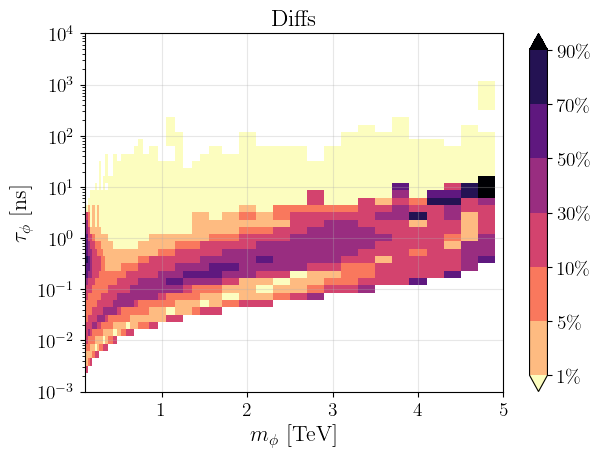

In [105]:
f = money_diff(eid2,eid1)
f.savefig("money_diff.pdf")
f

In [ ]:
f = make_money_τφ(eid2,eid1)
f.savefig("eR_LLP_diff.png", bbox_inches="tight", dpi=400)
f

In [10]:
eid_m = eid_mchi_Q(run_infos, 10e6, mchis, tauphi_u, tauphi_d)

(N_exp = [0.027357586022316846 0.0 … NaN NaN; 0.3791648638692409 0.15638827699817112 … NaN NaN; … ; 0.0 0.32638663934906914 … NaN NaN; 0.0 0.0 … NaN NaN;;; 0.38858106674905196 0.12354737467263188 … NaN NaN; 5.659869820204065 3.1756435710238895 … NaN NaN; … ; 0.0 0.11329364121862551 … NaN NaN; 0.0 0.0 … NaN NaN;;; 1.7774526260392516 0.9561309350427611 … NaN NaN; 21.346606971056296 18.113691737107562 … NaN NaN; … ; 0.0 0.11207554796051925 … NaN NaN; 0.0 0.0 … NaN NaN;;; 1.1019373434432942 0.534388370883755 … NaN NaN; 16.053105826839467 12.610128752841637 … NaN NaN; … ; 0.0 0.04069028571560538 … NaN NaN; 0.0 0.0 … NaN NaN;;; 0.0 0.0 … NaN NaN; 9.296881268483911 3.1774750950214155 … NaN NaN; … ; 0.0 8.144337738904888 … NaN NaN; 0.0 0.0 … NaN NaN;;; 9.389198360136616 3.7127595717097415 … NaN NaN; 151.49858094084814 89.01543036586067 … NaN NaN; … ; 0.0 2.678320098168985 … NaN NaN; 0.0 0.0 … NaN NaN;;; 34.264282191376886 19.281774199458624 … NaN NaN; 487.4231887390262 411.2282629595404 … NaN 

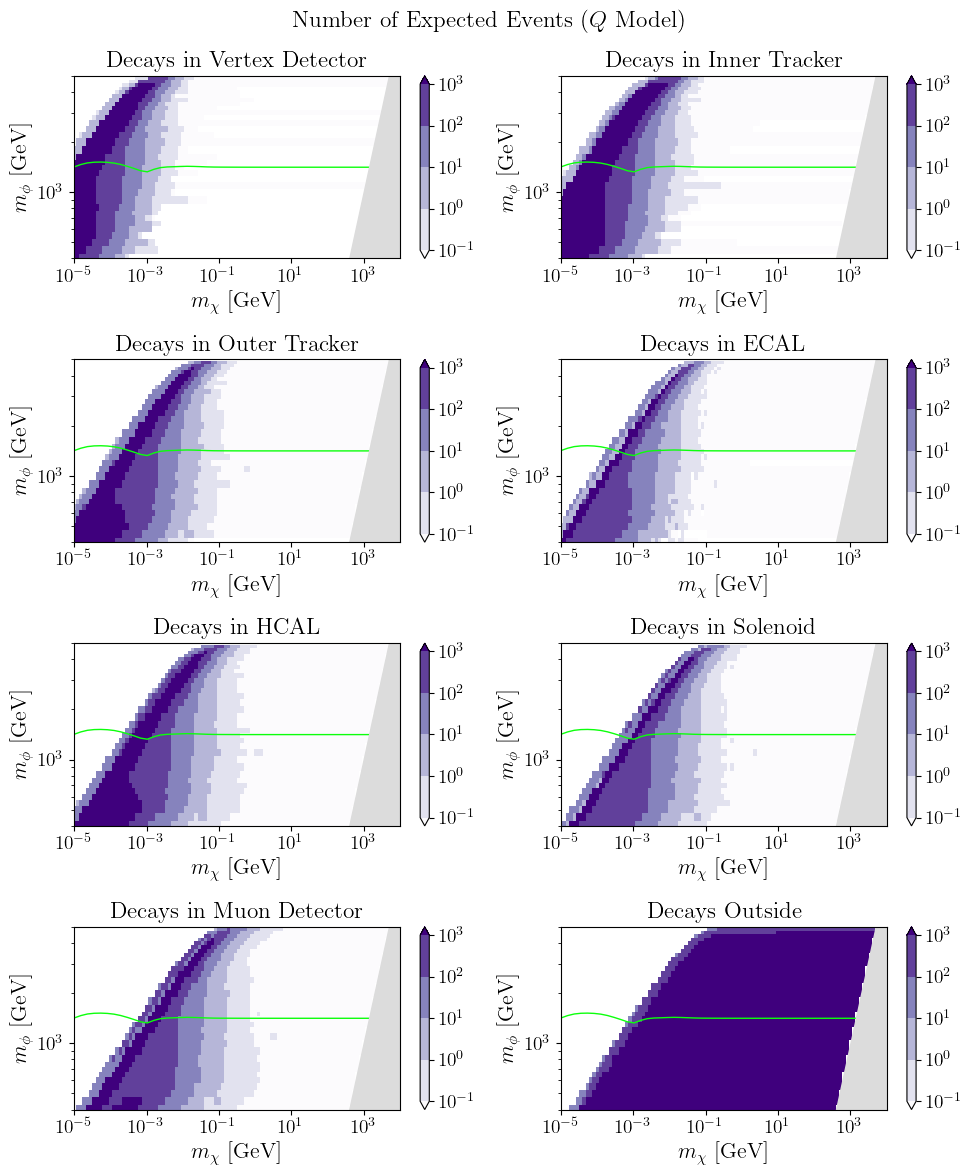

In [13]:
f = make_money(eid_m)
f.savefig("Q_LLP_events_mchi.png", bbox_inches="tight", dpi=400)
f